# Mumsnet Forum Analysis

In this notebook, I am going to be using unsupervised machine learning techniques to gain insights to different forums that Mumsnet have on their website.

### Importing relevant libraries and data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
from stop_words import get_stop_words
plt.style.use('ggplot')
import string

In [2]:
#reading in the data
data = pd.read_csv('mumsnet_test.csv')

def preprocess_data(df):
    """A function splits up the DateTime column into separate columns:
    - Year
    - Month
    - Day
    - Date
    - Time"""
    
    #make sure date column has the correct format
    data['DateTime'] = pd.to_datetime(data['DateTime'])
    
    #Creating the new columns.
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Date'] = df['DateTime'].dt.date
    df['Time'] = df['DateTime'].dt.time
    
    return df

data = preprocess_data(data)

### Info about the data:

- ID - is the unique identifier for a Mumsnet 'Thread' or Discussion page.
- Title - The Title of the page
- Forum - Mumsnet's Talk Forums it came from.
- DateTime - Timestamp from when the message was posted
- Message - The content of the message containing an amazon link

In [3]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.')

The data has 1463 rows and 10 columns.


In [4]:
#quick view of the data.
data.sort_values(by='DateTime').head()

,ID,Title,Forum,DateTime,Message,Year,Month,Day,Date,Time
1346,4091964,Can anyone recommend a drawing tablet please?,geeky_stuff,2020-12-02 08:07:35+00:00,[[https://www.amazon.co.uk/Wacom-Intuos-Draw-T...,2020,12,2,2020-12-02,08:07:35
129,4094703,What to do when you and DH fundamentally disag...,parenting,2020-12-02 11:01:34+00:00,"Buy him ""Babies and Toddlers for Men"" by Mark ...",2020,12,2,2020-12-02,11:01:34
1345,4091964,Can anyone recommend a drawing tablet please?,geeky_stuff,2020-12-02 11:08:40+00:00,This is the XP Pen one we got DSS: \n[[https:/...,2020,12,2,2020-12-02,11:08:40
128,4095813,Can anyone recommend some scales?,calorie_counting,2020-12-02 12:34:47+00:00,I have these ones. Do the job and cheap. [[htt...,2020,12,2,2020-12-02,12:34:47
1072,4095926,High chair to boaster seat,parenting,2020-12-02 13:39:20+00:00,We went from the Ikea highchair to a BabyDan h...,2020,12,2,2020-12-02,13:39:20


### Preprocessing the Data

Let's preprocess the data ready for cluster analysis

In [5]:
def format_text_data(my_string):
    
    '''Cleans up message column using regular expressions.
    This function does:
    - Makes all characters in string lower case
    - Removes \n characters.
    - Replaces amazon links with <link>
    - Removes some other unwanted charaters.'''
    
    my_string = my_string.lower()
    my_string = re.sub('\n', '', my_string)
    my_string = re.sub('http\S+', ' ', my_string)
    my_string = re.sub('\[\[.*\]\]', ' <link> ', my_string)
    my_string = re.sub('â€™', "'", my_string)
    my_string = re.sub('-', ' ', my_string)
    my_string = re.sub('amazon', ' ', my_string)
    my_string = re.sub('www', ' ', my_string)

    
    return my_string

#Apply the above function to my message column in the data.
data['Message'] = data['Message'].apply(format_text_data)

In [6]:
#Stop word dictionary.
personal_stop_words_list = ['<link>', 'dd', 'dh', 'dp', 'amazon', 'recommend', 'actually', 'ago', 'also', 'www']
my_stop_words = get_stop_words('en') + personal_stop_words_list

In [7]:
data['message_filtered'] = pd.Series([my_string.split() for my_string in data['Message'].values])
for i, my_string in enumerate(data['message_filtered'].values):
    data['message_filtered'].iloc[i] = [word for word in my_string if word not in my_stop_words]

G:\Users\Nikhil\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
sorted_data = data.groupby(['Forum'], as_index=False).count().sort_values(by='Message', ascending=False)

In [9]:
#number of forums to consider when clustering.
top_n = 25

top_n_forum_list = sorted_data.Forum.values[:top_n] #list of top_n_forums.

In [10]:
top_n_forum_list = sorted_data.Forum.values[:top_n]

In [11]:
forum_corpus = {}

#Create dict of all words that are said in each forum.
for _, array in data[data['Forum'].isin(top_n_forum_list)].iterrows():
    
    try: forum_corpus[array['Forum']] += array['message_filtered']
    except: forum_corpus[array['Forum']] = array['message_filtered']

#List of strings where each string contains all the words said in that forum.        
corpus = [' '.join(forum_word_list) for forum_word_list in forum_corpus.values()]

# Text Clustering

In this section we are going to:

- Create a relevant data structure which so we can perform tfidf
- Use a clustering algorithm to see which forums are similar based upon what text is being talked about on each forum.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
vectoriser = TfidfVectorizer(max_features=200, min_df=2, max_df=10, ngram_range=(2,2))
tfidf_matrix = vectoriser.fit_transform(corpus) 

In [14]:
from sklearn.manifold import TSNE

In [15]:
tsne_model = TSNE(n_components=2, perplexity=4, metric='euclidean', random_state=42)

X = tsne_model.fit_transform(tfidf_matrix)

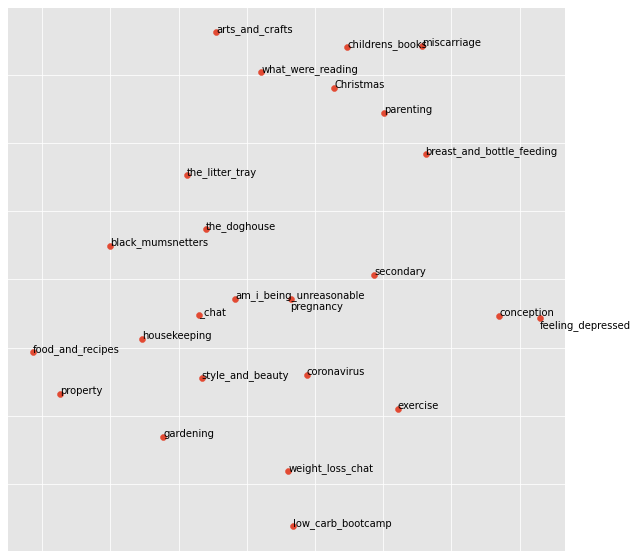

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=X[:,0], y=X[:,1])

for i, txt in enumerate(list(forum_corpus.keys())):
    #make sure text doesn't overlap.
    if txt in ['feeling_depressed', 'pregnancy']:
        ax.annotate(txt, (X[:,0][i], X[:,1][i]-15))
    else:
        ax.annotate(txt, (X[:,0][i], X[:,1][i]))
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
plt.savefig('forum_cluster.png')
plt.show()

#### Discussion

We see some interesting groups of forums which support our intution. Groups which are close together mean that similar words and word couples are being used together within those forums. 

We can deduce a few groups from this visual:

- In the middle bottom of the visualisation, we can see a group of fourums relating to fitness and health (exercise, weight loss chat, low carb bootcamp)
- At the top we see a group of forums which talk about children. (childrens books, christmas, parenting, breast and bottle feeding)
- The bottom left shows a group of forums to do with household things. (food, and recipes, property, housekeeping, gardening)

Note that we see the chat towards the middle of the visualisation. This supports our intution as there is no specific subject being talked suggesting what gets talked about on chat is a combination of many forums.

## Fitness and Health Forum Group Analysis

From the low carb bootcamp, weight loss chat and exercise forums, let's analyse what common bigrams are being used.

In [17]:
fitness_health_forum_list = ['exercise', 'weight_loss_chat', 'low_carb_bootcamp']
fitness_health_corpus_dict = {}

for forum_name in fitness_health_forum_list:
    
    fitness_health_corpus_dict[forum_name] = forum_corpus[forum_name]

fitness_health_corpus_list = [' '.join(forum_word_list) for forum_word_list in fitness_health_corpus_dict.values()]

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
count_vectoriser = CountVectorizer(max_features=200, min_df=2, max_df=10, ngram_range=(2,2))

X = count_vectoriser.fit_transform(fitness_health_corpus_list)

words_in_forum_list = count_vectoriser.get_feature_names()
word_count_sum = np.sum(X.toarray(), axis=0)

In [20]:
count_sorted, word_sorted = zip(*sorted(zip(word_count_sum, words_in_forum_list), reverse=True))

for i in range(len(word_sorted)):
    
    print(f'Bigram: {word_sorted[i]} | Count: {count_sorted[i]}')

Bigram: low carb | Count: 8
Bigram: suggest looking | Count: 2
Bigram: sounds like | Count: 2
Bigram: new book | Count: 2


## Household Forum Group Analysis

This group contains the house keeping, food and recipes, property and gardening forums

In [21]:
household_forum_list = ['property', 'food_and_recipes', 'gardening', 'housekeeping']
household_corpus_dict = {}

for forum_name in household_forum_list:
    
    household_corpus_dict[forum_name] = forum_corpus[forum_name]
    
household_corpus_list = [' '.join(forum_word_list) for forum_word_list in household_corpus_dict.values()]

In [22]:
count_vectoriser = CountVectorizer(max_features=200, min_df=2, max_df=10, ngram_range=(2,2))

X = count_vectoriser.fit_transform(household_corpus_list)

words_in_forum_list = count_vectoriser.get_feature_names()
word_count_sum = np.sum(X.toarray(), axis=0)

In [23]:
count_sorted, word_sorted = zip(*sorted(zip(word_count_sum, words_in_forum_list), reverse=True))

for i in range(len(word_sorted)):
    
    print(f'Bigram: {word_sorted[i]} | Count: {count_sorted[i]}')

Bigram: one these | Count: 7
Bigram: new one | Count: 3
Bigram: might worth | Count: 3
Bigram: like one | Count: 3
Bigram: well one | Count: 2
Bigram: these quote | Count: 2
Bigram: tend use | Count: 2
Bigram: one use | Count: 2
Bigram: one think | Count: 2
Bigram: looks like | Count: 2
Bigram: like can | Count: 2
Bigram: got one | Count: 2
Bigram: good quality | Count: 2
Bigram: go one | Count: 2
Bigram: can go | Count: 2
Bigram: bit like | Count: 2
Bigram: and or | Count: 2


## Children Forum Group Analysis

This group contains breast and bottle feeding, parenting, christmas, childrens books and miscarriage forums.

In [24]:
children_forum_list = ['breast_and_bottle_feeding', 'parenting',
                       'Christmas', 'childrens_books', 'miscarriage']
children_corpus_dict = {}

for forum_name in children_forum_list:
    
    children_corpus_dict[forum_name] = forum_corpus[forum_name]
    
children_corpus_list = [' '.join(forum_word_list) for forum_word_list in children_corpus_dict.values()]

In [25]:
count_vectoriser = CountVectorizer(max_features=200, min_df=2, max_df=10, ngram_range=(2,2))

X = count_vectoriser.fit_transform(children_corpus_list)

words_in_forum_list = count_vectoriser.get_feature_names()
word_count_sum = np.sum(X.toarray(), axis=0)

In [26]:
count_sorted, word_sorted = zip(*sorted(zip(word_count_sum, words_in_forum_list), reverse=True))

for i in range(len(word_sorted)):
    
    print(f'Bigram: {word_sorted[i]} | Count: {count_sorted[i]}')

Bigram: year old | Count: 17
Bigram: something like | Count: 8
Bigram: got one | Count: 7
Bigram: really good | Count: 6
Bigram: like it | Count: 5
Bigram: every day | Count: 5
Bigram: can add | Count: 5
Bigram: tongue tie | Count: 4
Bigram: sounds like | Count: 4
Bigram: one one | Count: 4
Bigram: might help | Count: 4
Bigram: make sure | Count: 4
Bigram: like one | Count: 4
Bigram: wondering whether | Count: 3
Bigram: try this | Count: 3
Bigram: though sure | Count: 3
Bigram: sun cream | Count: 3
Bigram: paw patrol | Count: 3
Bigram: one two | Count: 3
Bigram: olive oil | Count: 3
Bigram: old still | Count: 3
Bigram: much better | Count: 3
Bigram: lots different | Count: 3
Bigram: like this | Count: 3
Bigram: let know | Count: 3
Bigram: good quality | Count: 3
Bigram: facebook group | Count: 3
Bigram: colouring book | Count: 3
Bigram: can make | Count: 3
Bigram: can find | Count: 3
Bigram: ðÿ žðÿ | Count: 2
Bigram: will see | Count: 2
Bigram: will help | Count: 2
Bigram: will definit